In [347]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statistics

from statsmodels.stats import inter_rater as irr
from typing import *

In [348]:
import warnings
warnings.filterwarnings('ignore')

In [349]:
directory = "/Users/Millicent/Research/biomed-generation-analysis/biomed-generation-out"

In [350]:
results = {}

for path, _, files in os.walk(directory):
    for idx, file in enumerate(files):
        if file == ".DS_Store":
            continue
        else:
            final_path = os.path.join(path, file)
            data = []
            with open(final_path, "r") as f:
                for line in f:
                    data.append(json.loads(line))
            results[idx] = data

In [351]:
doc_idx = {}
for idx in range(10):
    doc_idx[idx + 1] = []

In [352]:
# Number of documents: should be 1 per person, times 4
for result in results:
    output = results[result][0]
    for question in output:
        doc_idx[question['data']['doc_idx']].append(question)

In [353]:
# Sanity check
for idx in doc_idx:
    assert len(doc_idx[idx]) == len(results)

In [354]:
# Aggregate headers for pandas
headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        for doc in document['annotations'][0]['result']:
            headers.append(doc['from_name'])
        break
    break

In [355]:
df = pd.DataFrame(columns=headers)
df['completed_by'] = df['completed_by'].astype(int)

In [359]:
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        data = {
            'doc_idx' : idx,
            'completed_by' : int(document['annotations'][0]['completed_by']),
            'abstract' : document['data']['abstract'],
            'key_result' : document['data']['text'],
            'summary' : document['data']['summary'],
            'plain_summary' : document['data']['plain_summary']
        }
        doc = document['annotations'][0]['result']
        for doc in document['annotations'][0]['result']:
            try:
                data[doc['from_name']] = doc['value']['choices'][0]
            except:
                data[doc['from_name']] = doc['value']
        df = df.append(data, ignore_index=True)

In [361]:
df_copy = df.copy(deep=True)

In [362]:
unwanted_headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
headers_of_interest = [header for header in headers if header not in unwanted_headers]

In [363]:
likert_rating = ["Strongly disagree", "Disagree", "Agree", "Strongly agree"]
technical_terms_rating = ["None at all", "Only a few", "Mostly all", "All"]
omissions_rating = ["No ommision", "Minor omission(s)", "Major omission(s)"]
errors_rating = ["No errors", "Minor error", "Major error"]
likert_rating_dict = {s : idx for idx, s in enumerate(likert_rating)}
technical_terms_rating_dict = {s : idx for idx, s in enumerate(technical_terms_rating)}
omission_rating_dict = {s : idx for idx, s in enumerate(omissions_rating)}
errors_rating_dict = {s : idx for idx, s in enumerate(errors_rating)}

population_rating = [
    "The population is not mentioned (missing) in the model summary",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating = [
    "The intervention is not mentioned (missing) in the model summary",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating = [
    "The outcome is not mentioned (missing) in the model summary",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]

population_rating_plain = [
    "The population is not mentioned (missing) in the simplified model text",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating_plain = [
    "The intervention is not mentioned (missing) in the simplified model text",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating_plain = [
    "The outcome is not mentioned (missing) in the simplified model text",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]
population_rating_dict = {s : idx for idx, s in enumerate(population_rating)}
intervention_rating_dict = {s : idx for idx, s in enumerate(intervention_rating)}
outcome_rating_dict = {s : idx for idx, s in enumerate(outcome_rating)}

population_rating_plain_dict = {s : idx for idx, s in enumerate(population_rating_plain)}
intervention_rating_plain_dict = {s : idx for idx, s in enumerate(intervention_rating_plain)}
outcome_rating_plain_dict = {s : idx for idx, s in enumerate(outcome_rating_plain)}

In [364]:
likert_ratings_list = []
likert_ratings_list.append('containsKeyResult')
likert_ratings_list.append('coherence')
likert_ratings_list.append('usefulness')
likert_ratings_list.append('containsKeyResult_plain')
likert_ratings_list.append('coherence_plain')
likert_ratings_list.append('readability_plain')
likert_ratings_list.append('usefulness_plain')

In [368]:
for  col in likert_ratings_list:
    df_copy[col] = df_copy[col].astype('string')
    df_copy[col].replace(to_replace="Strongly disagree", value="Disagree", inplace=True, regex=True)
    df_copy[col].replace(to_replace="Strongly agree", value="Agree", inplace=True, regex=True)
    # df_copy[col] = df_copy[col].str.replace("[']", "", regex=True)
    df_copy[col] = df_copy[col].astype('object')

In [370]:
rating_mapping = {
    'containsKeyResult' : likert_rating_dict,
    'population' : population_rating_dict,
    'intervention' : intervention_rating_dict,
    'outcome' : outcome_rating_dict,
    'omissions' : omission_rating_dict,
    'errors' : errors_rating_dict,
    'coherence' : likert_rating_dict,
    'usefulness' : likert_rating_dict,
    'containsKeyResult_plain' : likert_rating_dict,
    'population_plain' : population_rating_plain_dict,
    'intervention_plain' : intervention_rating_plain_dict,
    'outcome_plain' : outcome_rating_plain_dict,
    'omissions_plain' : omission_rating_dict,
    'errors_plain' : errors_rating_dict,
    'coherence_plain' : likert_rating_dict,
    'readability_plain' : likert_rating_dict,
    'substitution_plain' : technical_terms_rating_dict,
    'usefulness_plain' : likert_rating_dict,
}

In [371]:
likert_rating_dict_collapsed = {}
for idx, s in enumerate(likert_rating):
    if s == "Strongly disagree" or s == "Disagree":
        likert_rating_dict_collapsed[s] = 0
    elif s == "Strongly agree" or s == "Agree":
        likert_rating_dict_collapsed[s] = 1
    else:
        likert_rating

rating_mapping_collapsed = {
    'containsKeyResult' : likert_rating_dict_collapsed,
    'population' : population_rating_dict,
    'intervention' : intervention_rating_dict,
    'outcome' : outcome_rating_dict,
    'omissions' : omission_rating_dict,
    'errors' : errors_rating_dict,
    'coherence' : likert_rating_dict_collapsed,
    'usefulness' : likert_rating_dict_collapsed,
    'containsKeyResult_plain' : likert_rating_dict_collapsed,
    'population_plain' : population_rating_plain_dict,
    'intervention_plain' : intervention_rating_plain_dict,
    'outcome_plain' : outcome_rating_plain_dict,
    'omissions_plain' : omission_rating_dict,
    'errors_plain' : errors_rating_dict,
    'coherence_plain' : likert_rating_dict_collapsed,
    'readability_plain' : likert_rating_dict_collapsed,
    'substitution_plain' : technical_terms_rating_dict,
    'usefulness_plain' : likert_rating_dict_collapsed,
}

In [372]:
headers_of_interest

['containsKeyResult',
 'population',
 'intervention',
 'outcome',
 'omissions',
 'errors',
 'coherence',
 'usefulness',
 'containsKeyResult_plain',
 'population_plain',
 'intervention_plain',
 'outcome_plain',
 'omissions_plain',
 'errors_plain',
 'coherence_plain',
 'readability_plain',
 'substitution_plain',
 'usefulness_plain']

In [393]:
# Functions for analysis
def get_by_doc_idx(df, id: int) -> pd.DataFrame:
    return df.loc[df['doc_idx'] == id]

def get_distribution(df: pd.DataFrame, column: str) -> Union[List[str], List[str], List[str]]:
    df_curr = df.loc[:, column]
    ratings = rating_mapping[column]
    labels = df_curr.to_numpy()
    labels = [label for label in labels]
    distribution = np.zeros(len(ratings))
    for label in labels:
        idx = ratings[label]
        distribution[idx] += 1
    return distribution, labels, ratings

def get_distribution_collapsed(df: pd.DataFrame, column: str) -> Union[List[str], List[str], List[str]]:
    df_curr = df.loc[:, column]
    ratings = rating_mapping_collapsed[column]
    labels = df_curr.to_numpy()
    labels = [label[0] for label in labels]
    max_idx = max(ratings[key] for key in ratings)
    distribution = np.zeros(max_idx + 1)
    for label in labels:
        idx = ratings[label]
        distribution[idx] += 1
    return distribution, labels, ratings

# SHOULD BE SUBJECT/SAMPLE x RATER AS THE RETURN RESULT -- ACROSS ONE TYPE OF COLUMN
# Assigning a # means the assigned category
# From https://stackoverflow.com/a/70117023
def get_sample_by_choice(df: pd.DataFrame, column: str) -> List[str]:
    ratings = rating_mapping[column]
    max_doc_idx = 10
    output = []
    for idx in range(max_doc_idx):
        docs = get_by_doc_idx(df, idx + 1)
        # Get the column we want now for this specific doc_idx (doc 1, doc 2, doc 3, etc)
        df_curr = docs.loc[:, column]
        labels = df_curr.to_numpy()
        labels = [label for label in labels]
        distribution = np.zeros(len(df_curr))
        for i, label in enumerate(labels):
            distribution[i] = ratings[label]
        output.append(distribution)

    return np.array(output)

def plot_distributions_and_all(df: pd.DataFrame, columns: List[str]) -> None:
    for idx, column in enumerate(columns):
        distribution, _, ratings = get_distribution(df, column)
        variance, mean, stddev = get_statistics(distribution)
        kappa = get_fleiss_kappa(df, column)
        print(f"Statistics for {column}:\n    Variance: {variance}\n    Mean: {mean}\n    Std Dev: {stddev}\n    Fleiss Kappa: {kappa}")
        # fig, axs = plt.subplots(1, 18, figsize=(15,15))
        x = np.arange(len(distribution))
        y = np.arange(int(max(distribution)))
        # print("Here's x:", x)
        # print("Here's y:", y)
        # x_index = idx % 9
        # y_index = int(idx // 9)
        ratings_as_labels = [key for key in ratings]
        plt.bar(ratings_as_labels, distribution)
        # plt.xticks(labels)
        plt.xticks(rotation = 90)
        plt.yticks(y)
        plt.title(column)
        plt.xlabel("Agreement Type")
        plt.ylabel("Frequency")

        # print("Here's x_index:", x_index)
        # print("Here's y_index:", y_index)
        # print()
        # axs[x_index, y_index].set_xticks(x)
        # axs[x_index, y_index].set_yticks(y)
        # axs[x_index, y_index].set_xticklabels("Agreement Type")
        # axs[x_index, y_index].set_yticklabels("Frequency")
        # axs[x_index, y_index].bar(x, distribution)
        # axs[x_index, y_index].title(column)
        # axs[idx].set_xticks(x)
        # axs[idx].set_yticks(y)
        # axs[idx].set_xticklabels("Agreement Type")
        # axs[idx].set_yticklabels("Frequency")
        # axs[idx].bar(x, distribution)
        # axs[idx].title(column)
        plt.show()

def plot_distributions_and_all_collapsed(df: pd.DataFrame, columns: List[str]) -> None:
    for idx, column in enumerate(columns):
        distribution, _, ratings = get_distribution_collapsed(df, column)
        variance, mean, stddev = get_statistics(distribution)
        kappa = get_fleiss_kappa_collapsed(df, column)
        print(f"Statistics for {column}:\n    Variance: {variance}\n    Mean: {mean}\n    Std Dev: {stddev}\n    Fleiss Kappa: {kappa}")
        # fig, axs = plt.subplots(1, 18, figsize=(15,15))
        x = np.arange(len(distribution))
        y = np.arange(int(max(distribution)))
        ratings_as_labels = [key for key in ratings]
        ratings = []
        for key in ratings_as_labels:
            if key == "Strongly agree" or key == "Strongly disagree":
                continue
            else:
                ratings.append(key)

        ratings_as_labels = ratings
        plt.bar(ratings_as_labels, distribution)
        plt.xticks(rotation = 90)
        plt.yticks(y)
        plt.title(column)
        plt.xlabel("Agreement Type")
        plt.ylabel("Frequency")
        plt.show()

def get_fleiss_kappa(df: pd.DataFrame, column: List[str]):
    """
    Some information on kappas:
    Null Hypothesis Kappa = 0	Agreement is due to chance
    0.01-0.020	Slight agreement
    0.21-0.40	Fair Agreement
    0.41-0.60	Moderate Agreement
    0.61-0.80	Substantial Agreement
    0.81-1.00	Almost Perfect Agreement
    Negative (Kappa<0)	Agreement less than that expected by chance
    """
    # Should be subject/sample x rater
    distribution = get_sample_by_choice(df, column)
    # Should be subject/sample x cat counts
    aggregated = irr.aggregate_raters(distribution)
    
    # Debug prints
    # print("Here's distribution:", distribution)
    # print("Here's aggregated:", aggregated)
    return irr.fleiss_kappa(aggregated[0], method='fleiss')

# def get_fleiss_kappa_collapsed(df: pd.DataFrame, column: List[str]):
#     """
#     Some information on kappas:
#     Null Hypothesis Kappa = 0	Agreement is due to chance
#     0.01-0.020	Slight agreement
#     0.21-0.40	Fair Agreement
#     0.41-0.60	Moderate Agreement
#     0.61-0.80	Substantial Agreement
#     0.81-1.00	Almost Perfect Agreement
#     Negative (Kappa<0)	Agreement less than that expected by chance
#     """

#     # Should be subject/sample x rater
#     distribution = get_sample_by_choice(df, column)
#     # Should be subject/sample x cat counts
#     aggregated = irr.aggregate_raters(distribution)
    
#     # Debug prints
#     # print("Here's distribution:", distribution)
#     # print("Here's aggregated:", aggregated)
#     return irr.fleiss_kappa(aggregated[0], method='fleiss')


def get_statistics(distribution: List[int]) -> Union[float, float]:
    values_per_label = []
    for idx, d in enumerate(distribution):
        l = [idx for _ in range(int(d))]
        values_per_label.extend(l)

    return statistics.variance(values_per_label), \
            statistics.mean(values_per_label), \
            statistics.stdev(values_per_label)

Statistics for containsKeyResult:
    Variance: 0.20363636363636364
    Mean: 1.72
    Std Dev: 0.451260859854213
    Fleiss Kappa: 0.2504409171075839


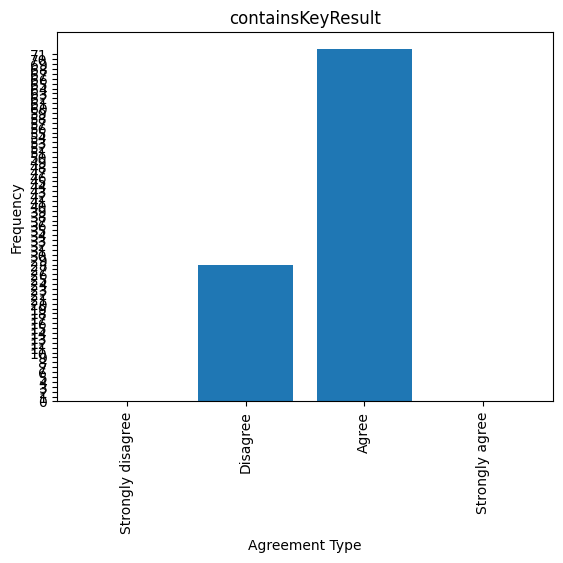

Statistics for population:
    Variance: 2.435959595959596
    Mean: 2.78
    Std Dev: 1.5607560975244004
    Fleiss Kappa: 0.38423645320197064


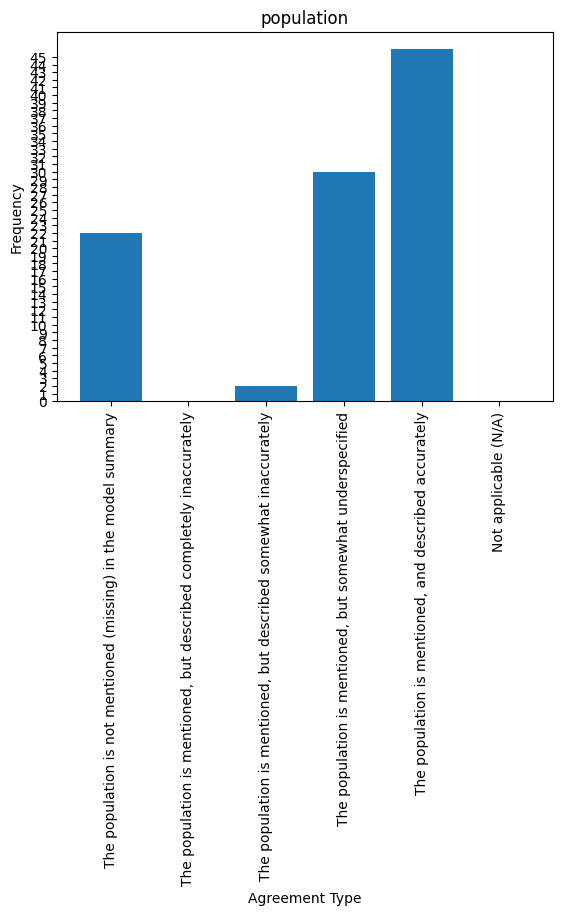

Statistics for intervention:
    Variance: 0.6561616161616162
    Mean: 3.48
    Std Dev: 0.8100380337747211
    Fleiss Kappa: 0.08256880733944978


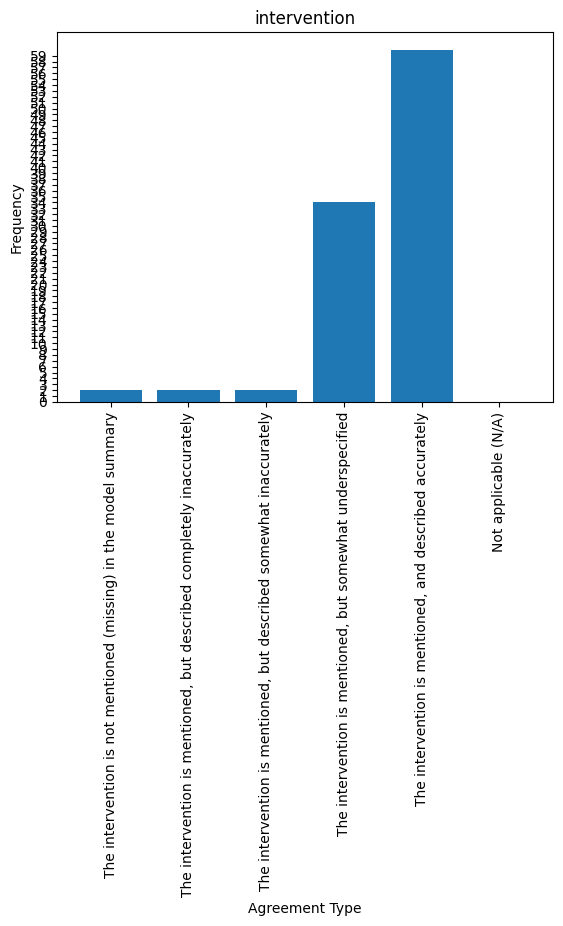

Statistics for outcome:
    Variance: 0.7115151515151515
    Mean: 3.34
    Std Dev: 0.8435135751813077
    Fleiss Kappa: 0.15442812639074316


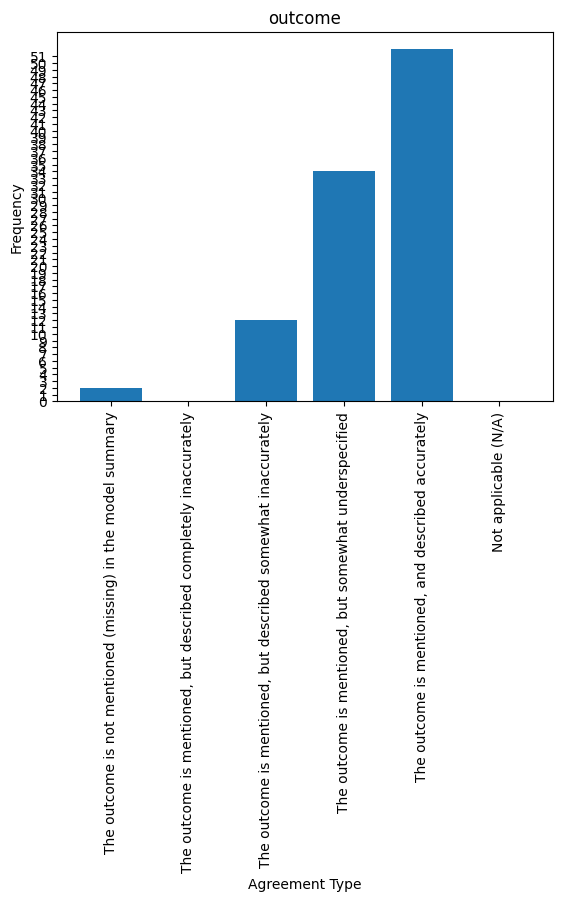

Statistics for omissions:
    Variance: 0.5854545454545454
    Mean: 0.98
    Std Dev: 0.7651500150000295
    Fleiss Kappa: 0.1181657848324515


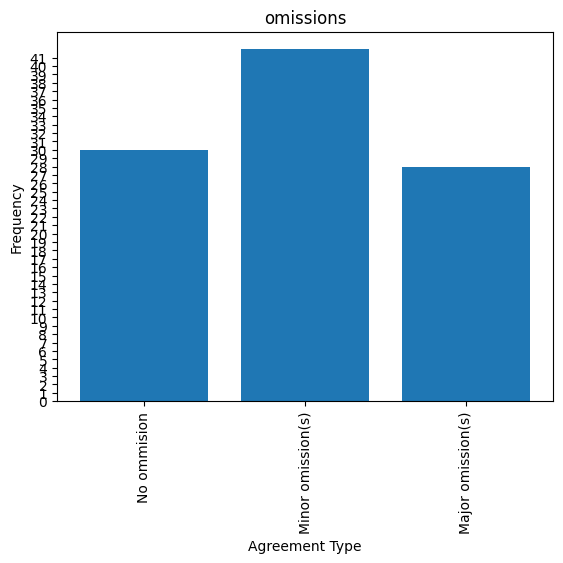

Statistics for errors:
    Variance: 0.29454545454545455
    Mean: 0.22
    Std Dev: 0.5427204202399746
    Fleiss Kappa: 0.05033238366571738


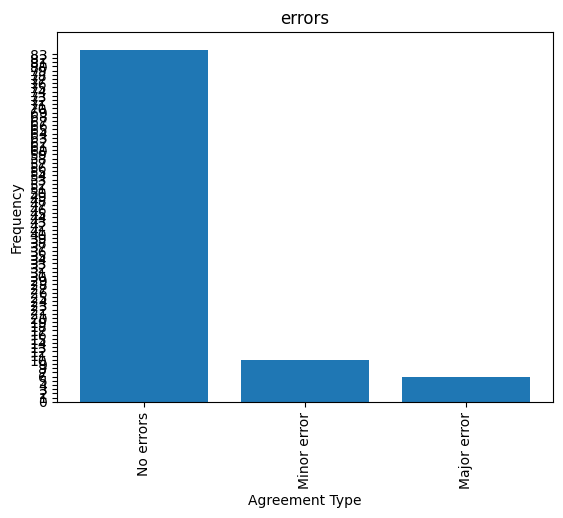

Statistics for coherence:
    Variance: 0.03878787878787879
    Mean: 1.96
    Std Dev: 0.19694638556693236
    Fleiss Kappa: 0.0740740740740722


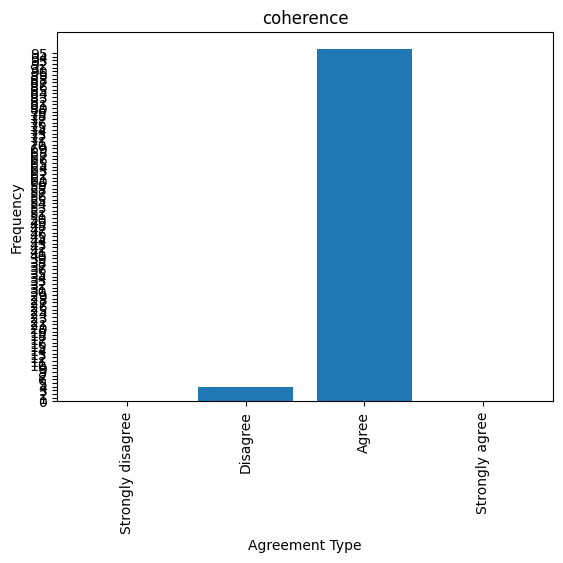

Statistics for usefulness:
    Variance: 0.16161616161616163
    Mean: 1.8
    Std Dev: 0.40201512610368484
    Fleiss Kappa: 0.38888888888888845


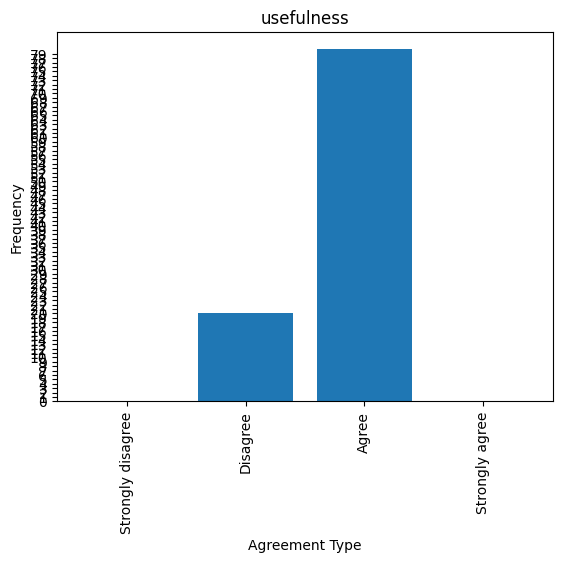

Statistics for containsKeyResult_plain:
    Variance: 0.20363636363636364
    Mean: 1.72
    Std Dev: 0.451260859854213
    Fleiss Kappa: 0.16225749559082878


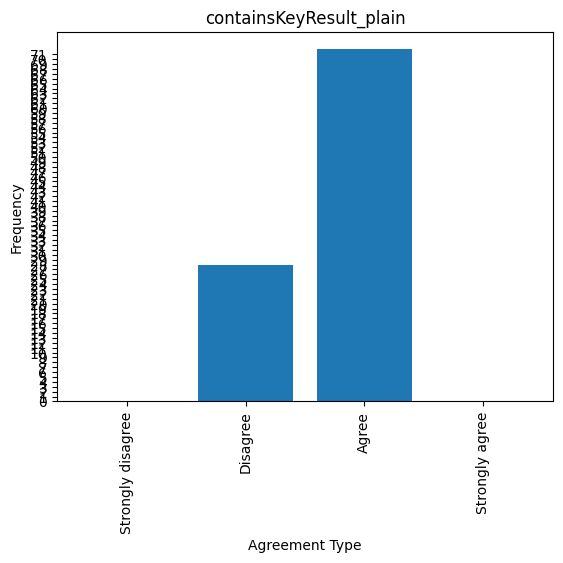

Statistics for population_plain:
    Variance: 2.676767676767677
    Mean: 2.7
    Std Dev: 1.6360830286900714
    Fleiss Kappa: 0.22480620155038766


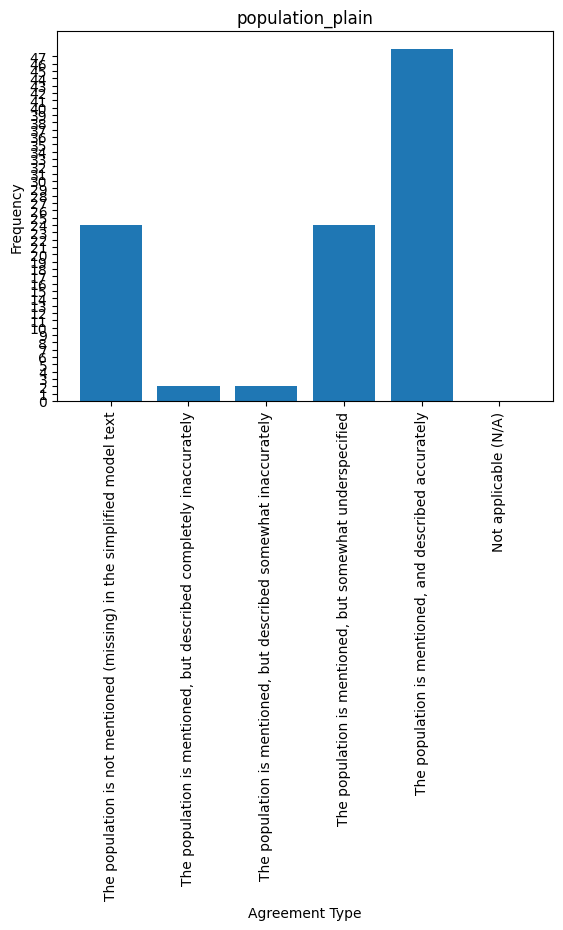

Statistics for intervention_plain:
    Variance: 0.898989898989899
    Mean: 3.3
    Std Dev: 0.9481507786158797
    Fleiss Kappa: 0.25723813854782485


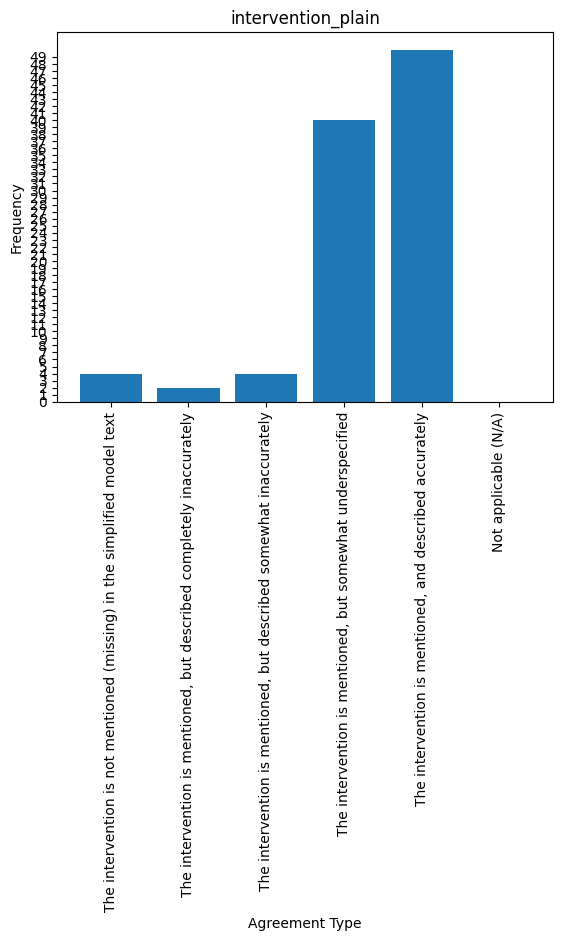

Statistics for outcome_plain:
    Variance: 0.6076767676767677
    Mean: 3.28
    Std Dev: 0.7795362516758074
    Fleiss Kappa: 0.3339831059129306


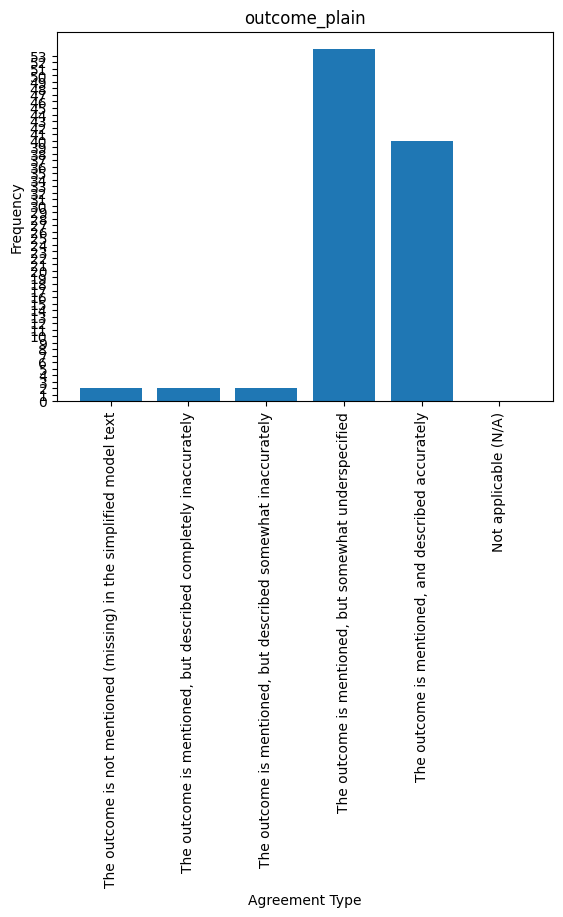

Statistics for omissions_plain:
    Variance: 0.6852525252525253
    Mean: 0.96
    Std Dev: 0.8277998098891575
    Fleiss Kappa: 0.2254273504273504


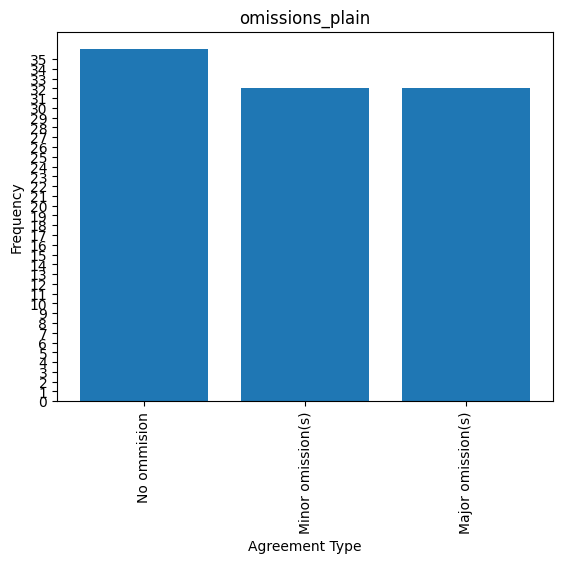

Statistics for errors_plain:
    Variance: 0.22787878787878788
    Mean: 0.12
    Std Dev: 0.47736651315188405
    Fleiss Kappa: 0.054373522458628754


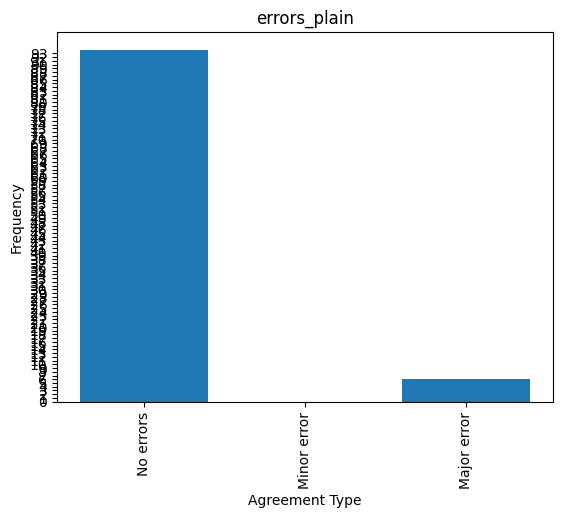

Statistics for coherence_plain:
    Variance: 0.019797979797979797
    Mean: 1.98
    Std Dev: 0.14070529413628968
    Fleiss Kappa: 0.0929705215419528


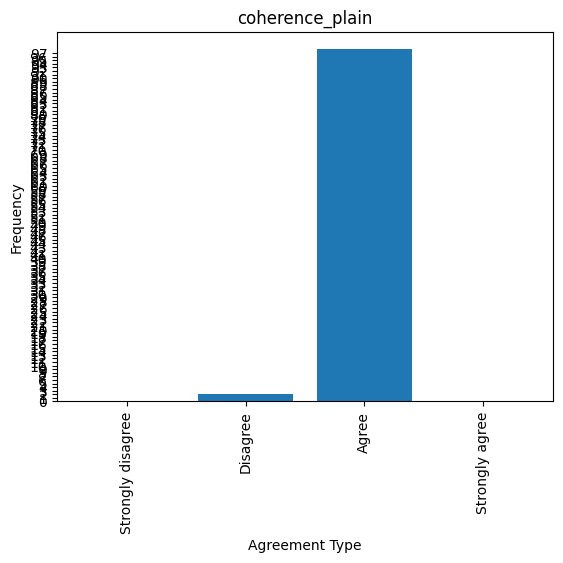

Statistics for readability_plain:
    Variance: 0.09090909090909091
    Mean: 1.9
    Std Dev: 0.30151134457776363
    Fleiss Kappa: 0.20987654320987612


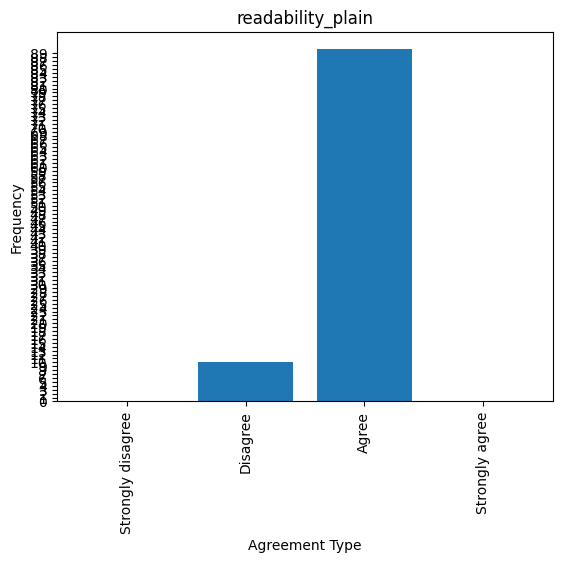

Statistics for substitution_plain:
    Variance: 0.6711111111111111
    Mean: 2.34
    Std Dev: 0.8192137151629671
    Fleiss Kappa: 0.18588873812754408


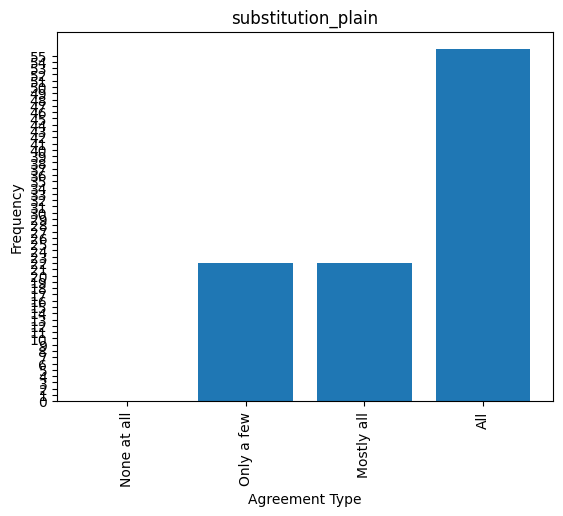

Statistics for usefulness_plain:
    Variance: 0.09090909090909091
    Mean: 1.9
    Std Dev: 0.30151134457776363
    Fleiss Kappa: 0.012345679012345146


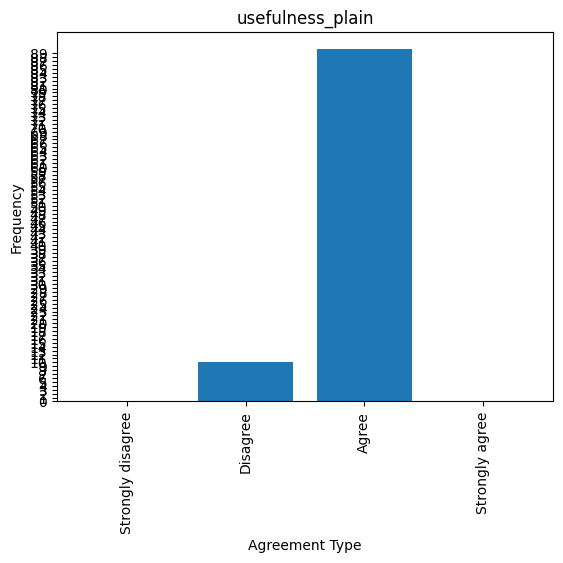

In [395]:
plot_distributions_and_all(df_copy, headers_of_interest)

Statistics for containsKeyResult:
    Variance: 0.9276767676767677
    Mean: 2.04
    Std Dev: 0.9631597830457663
    Fleiss Kappa: 0.12551440329218097


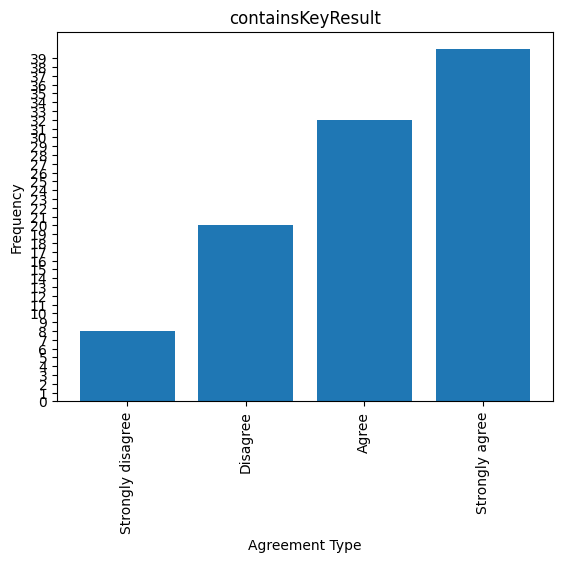

Statistics for population:
    Variance: 2.435959595959596
    Mean: 2.78
    Std Dev: 1.5607560975244004
    Fleiss Kappa: 0.38423645320197064


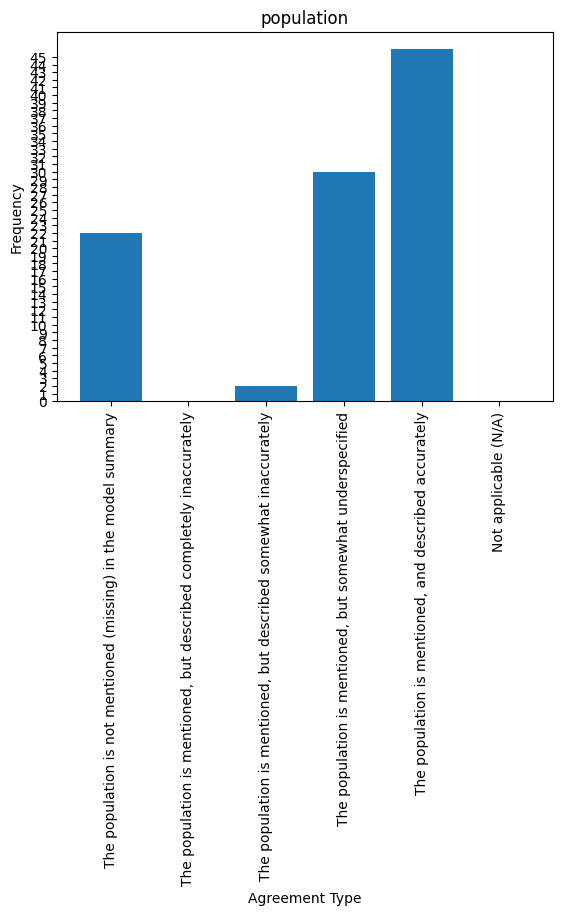

Statistics for intervention:
    Variance: 0.6561616161616162
    Mean: 3.48
    Std Dev: 0.8100380337747211
    Fleiss Kappa: 0.08256880733944978


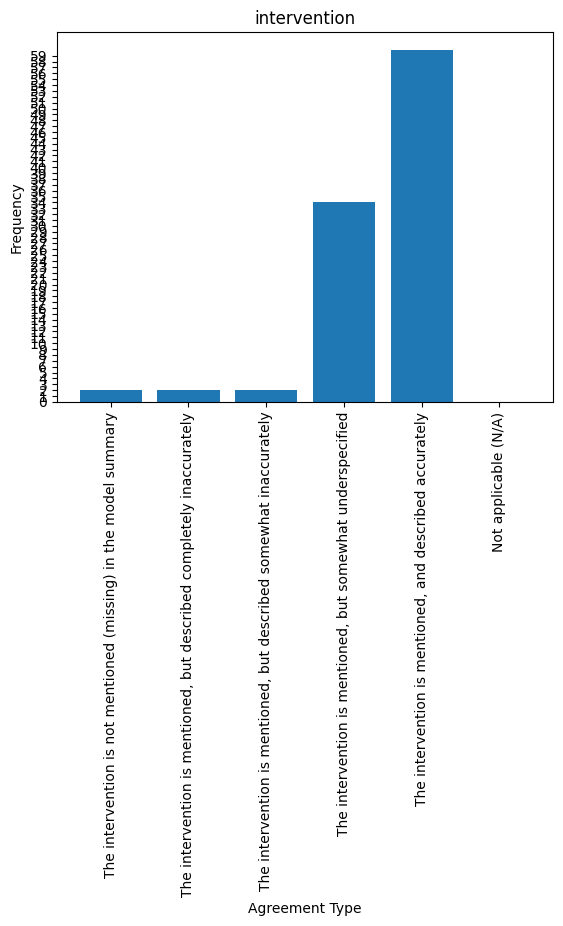

Statistics for outcome:
    Variance: 0.7115151515151515
    Mean: 3.34
    Std Dev: 0.8435135751813077
    Fleiss Kappa: 0.15442812639074316


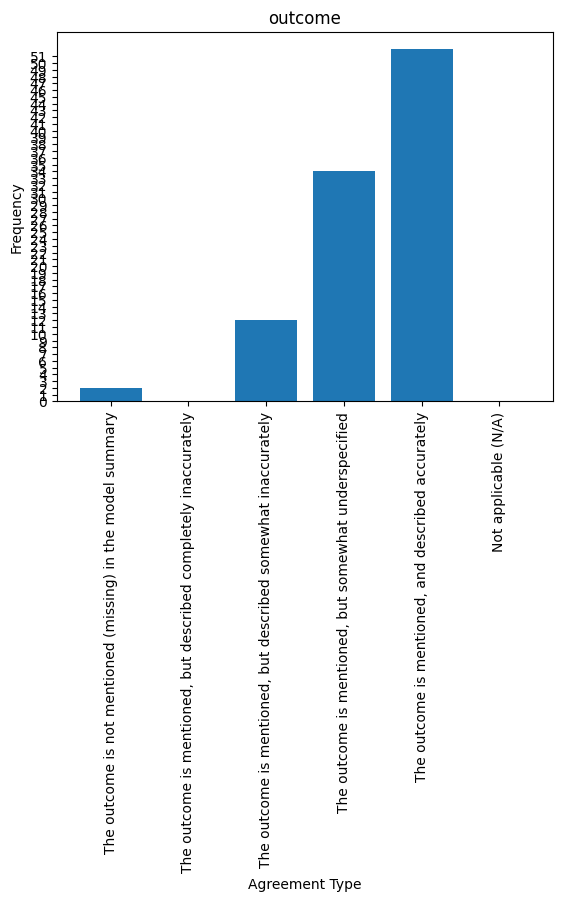

Statistics for omissions:
    Variance: 0.5854545454545454
    Mean: 0.98
    Std Dev: 0.7651500150000295
    Fleiss Kappa: 0.1181657848324515


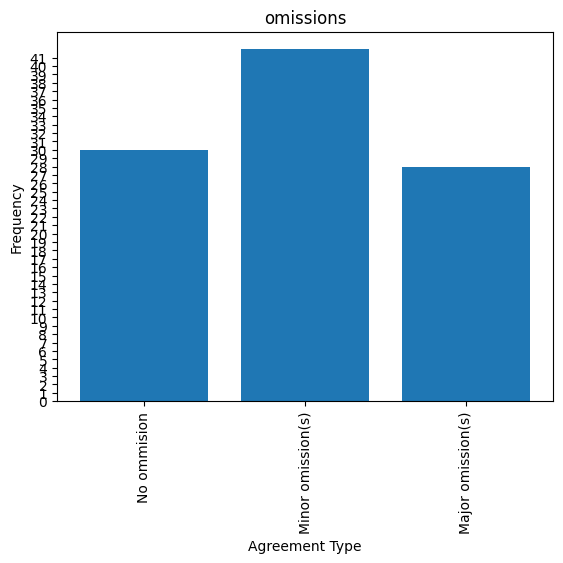

Statistics for errors:
    Variance: 0.29454545454545455
    Mean: 0.22
    Std Dev: 0.5427204202399746
    Fleiss Kappa: 0.05033238366571738


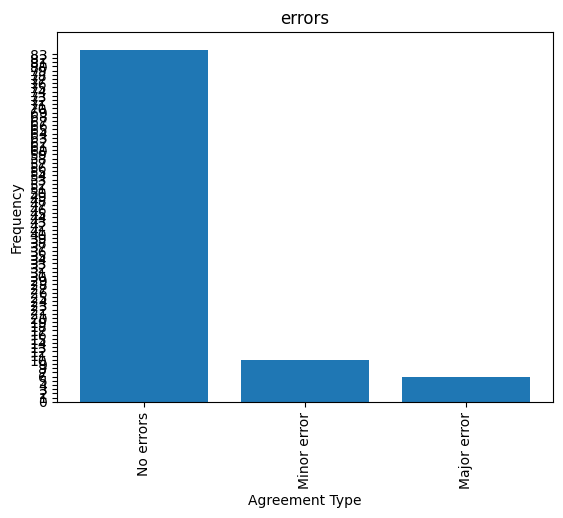

Statistics for coherence:
    Variance: 0.2298989898989899
    Mean: 2.82
    Std Dev: 0.4794778304562057
    Fleiss Kappa: 0.10682386566630953


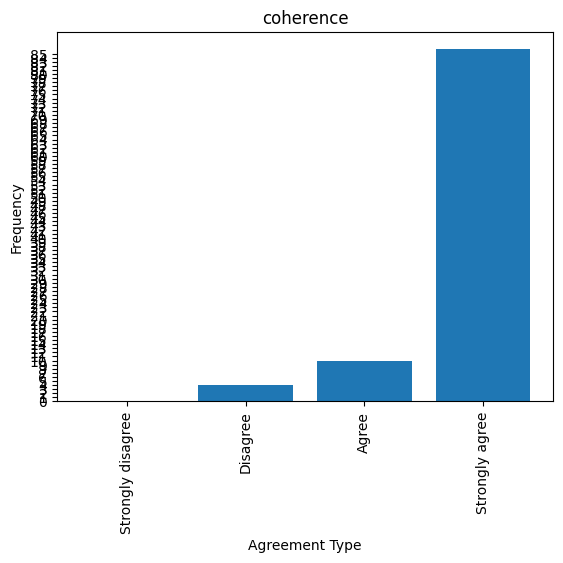

Statistics for usefulness:
    Variance: 0.6339393939393939
    Mean: 2.18
    Std Dev: 0.7962031109832427
    Fleiss Kappa: 0.20340612553220713


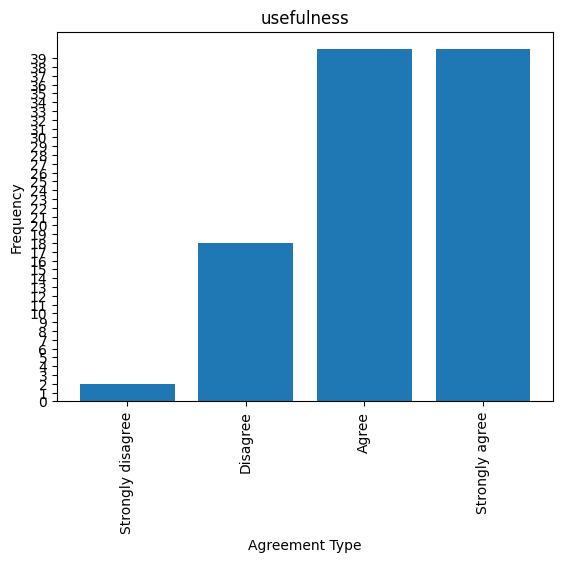

Statistics for containsKeyResult_plain:
    Variance: 0.9276767676767677
    Mean: 1.96
    Std Dev: 0.9631597830457663
    Fleiss Kappa: 0.20998980632008155


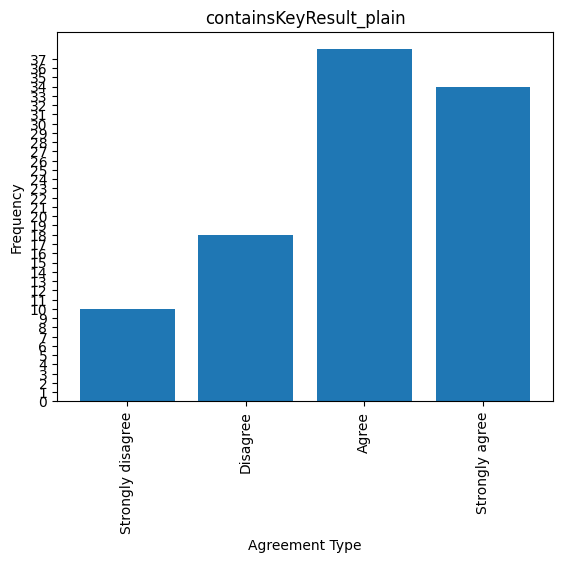

Statistics for population_plain:
    Variance: 2.676767676767677
    Mean: 2.7
    Std Dev: 1.6360830286900714
    Fleiss Kappa: 0.22480620155038766


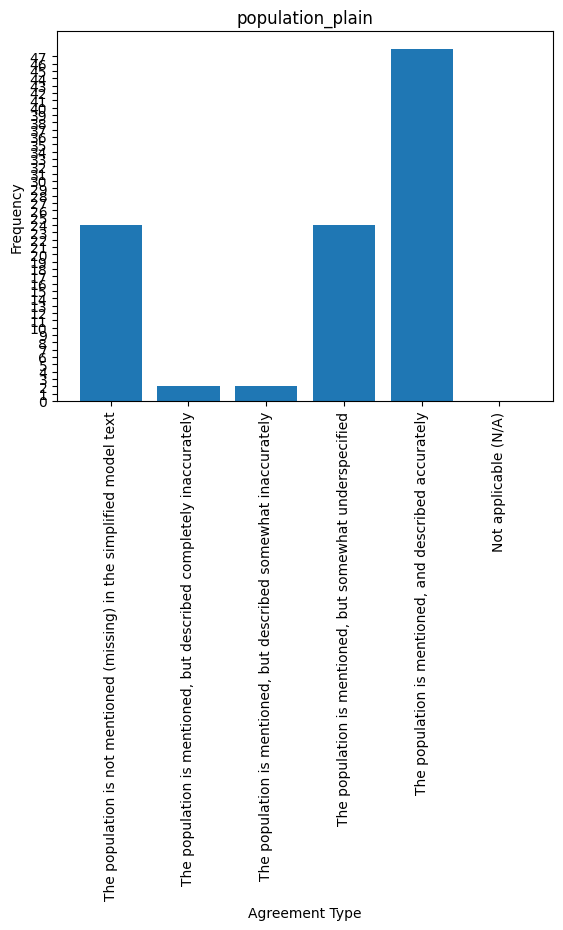

Statistics for intervention_plain:
    Variance: 0.898989898989899
    Mean: 3.3
    Std Dev: 0.9481507786158797
    Fleiss Kappa: 0.25723813854782485


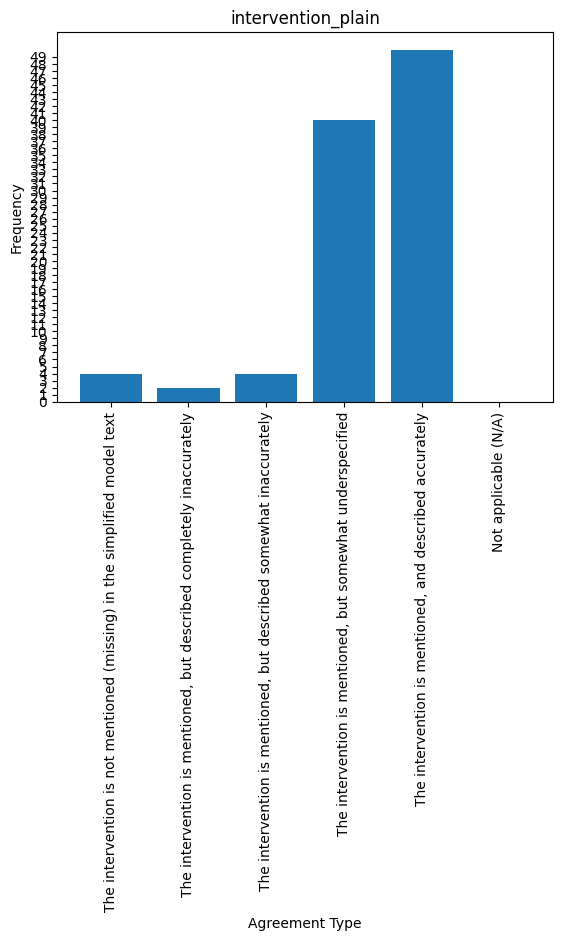

Statistics for outcome_plain:
    Variance: 0.6076767676767677
    Mean: 3.28
    Std Dev: 0.7795362516758074
    Fleiss Kappa: 0.3339831059129306


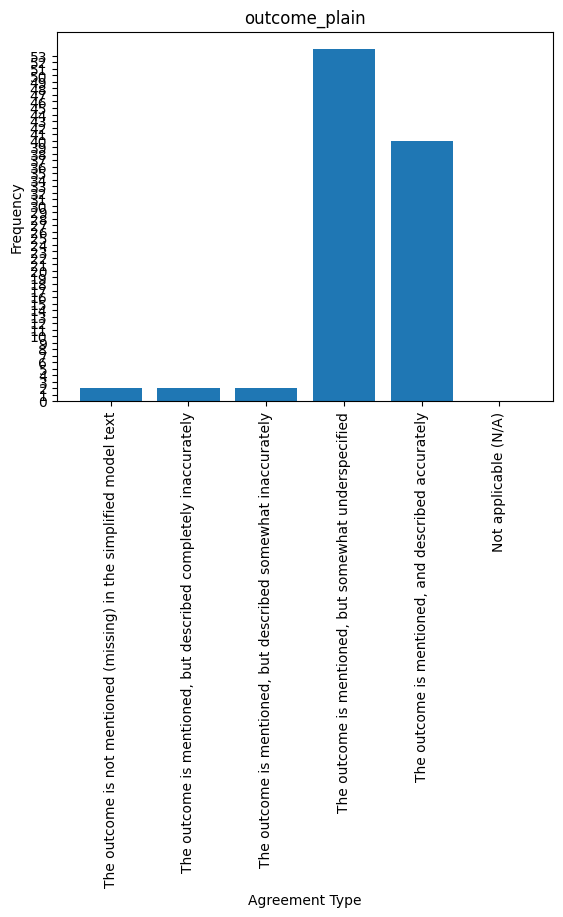

Statistics for omissions_plain:
    Variance: 0.6852525252525253
    Mean: 0.96
    Std Dev: 0.8277998098891575
    Fleiss Kappa: 0.2254273504273504


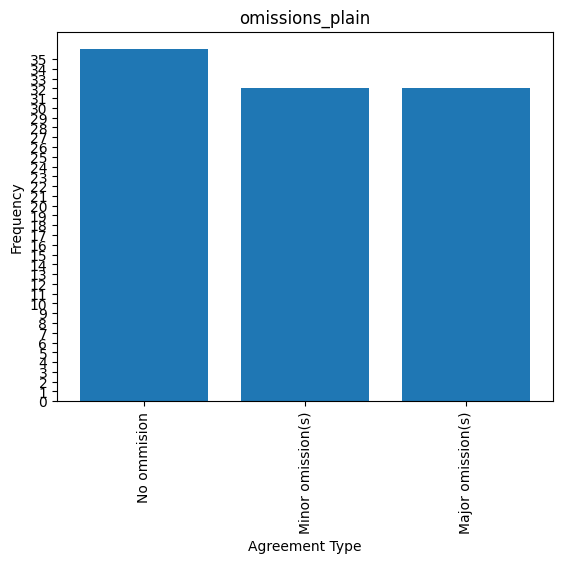

Statistics for errors_plain:
    Variance: 0.22787878787878788
    Mean: 0.12
    Std Dev: 0.47736651315188405
    Fleiss Kappa: 0.054373522458628754


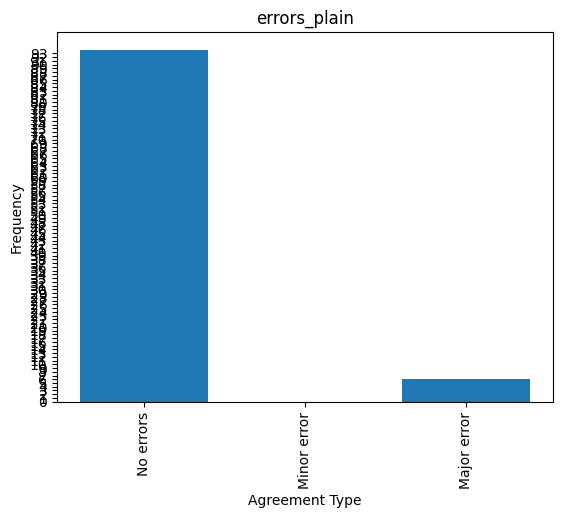

Statistics for coherence_plain:
    Variance: 0.1894949494949495
    Mean: 2.82
    Std Dev: 0.4353101761904372
    Fleiss Kappa: 0.06057661159702008


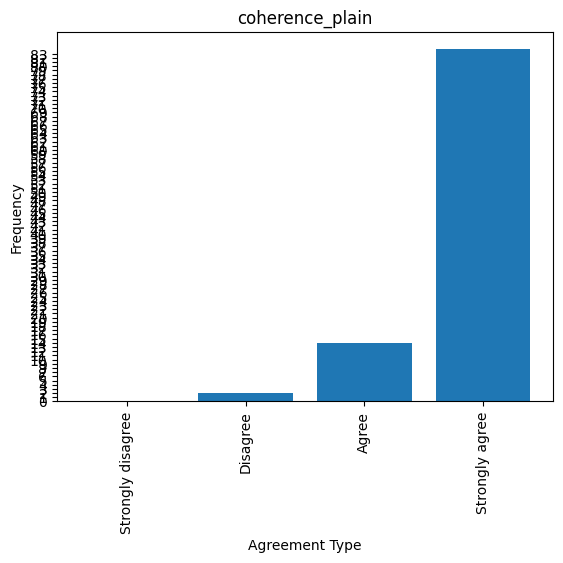

Statistics for readability_plain:
    Variance: 0.44
    Mean: 2.62
    Std Dev: 0.6633249580710799
    Fleiss Kappa: 0.2106860959319976


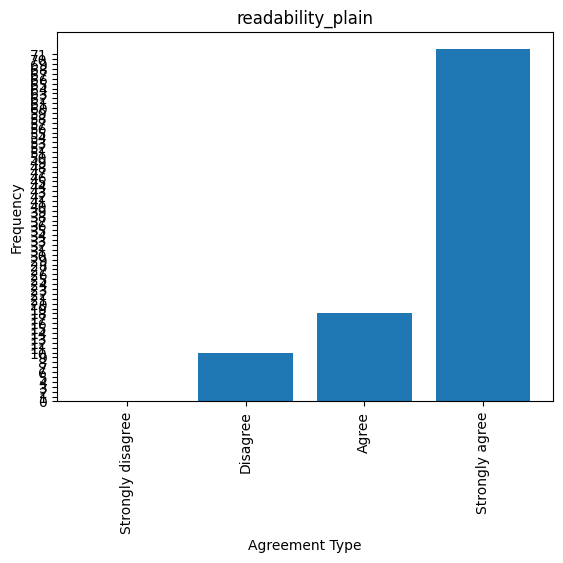

Statistics for substitution_plain:
    Variance: 0.6711111111111111
    Mean: 2.34
    Std Dev: 0.8192137151629671
    Fleiss Kappa: 0.18588873812754408


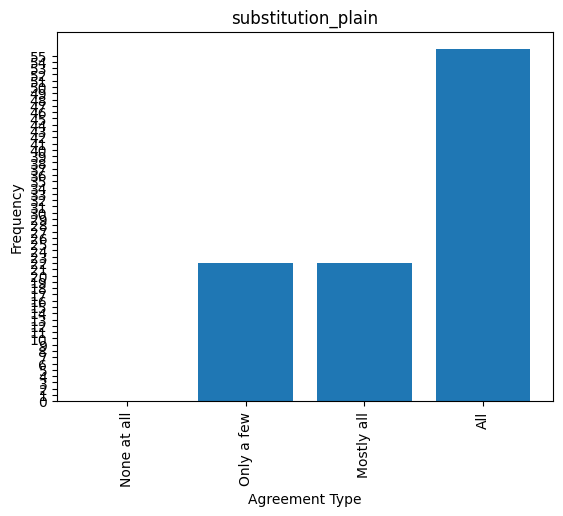

Statistics for usefulness_plain:
    Variance: 0.4444444444444444
    Mean: 2.2
    Std Dev: 0.6666666666666666
    Fleiss Kappa: 0.08609908609908623


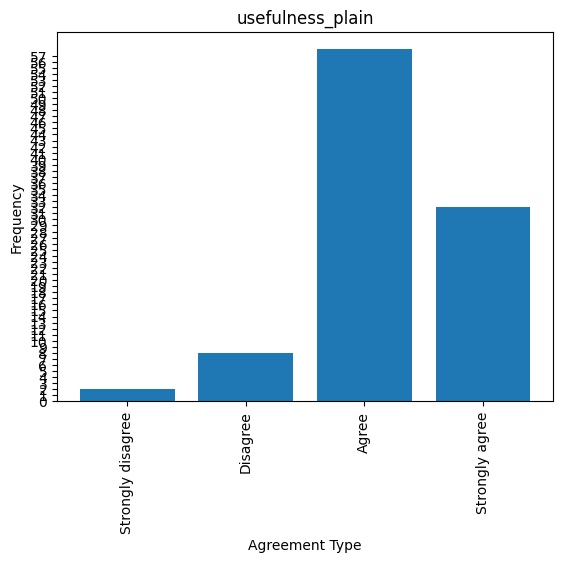

In [394]:
plot_distributions_and_all(df, headers_of_interest)